In [28]:
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import os
import zarr
import matplotlib.colors as mcolors

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    max_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    min_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    raising      (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] 196kB dask.array<chunk

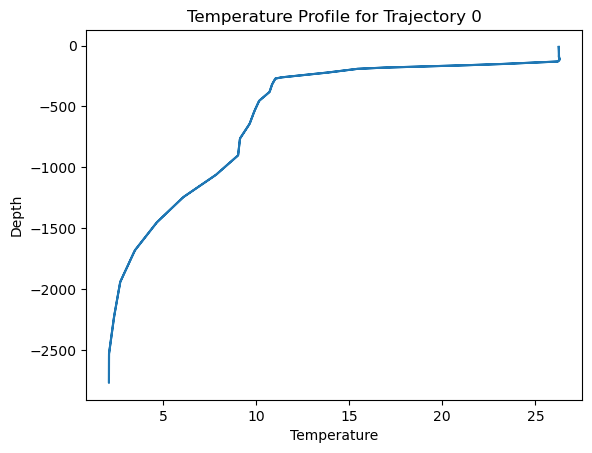

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:12:00'), 'temperature': 26.256418228149414, 'salinity': 34.966346740722656, 'z': -11.0, 'trajectory': 38, 'obs': 0}


In [29]:
"""
This cell just loads the data and puts it all first in a dataframe, and then in a data dictionary. I'm not sure why it works with a datadict but
I checked it with print statements and the data is fine afaik.
"""
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Open the Zarr dataset
datadir = r"C:\Users\gvp63\Downloads\results (2)\somalia\results\ctd.zarr"
ds = xr.open_zarr(datadir)

# Inspect dataset
print(ds)

# Count the number of trajectories and observations
num_trajectories = ds.sizes['trajectory']
num_observations = ds.sizes['obs']
print(f"Number of trajectories: {num_trajectories}")
print(f"Number of observations per trajectory: {num_observations}")

# Plot temperature vs depth for the first trajectory
plt.plot(ds['temperature'].isel(trajectory=0), ds['z'].isel(trajectory=0))
plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.title('Temperature Profile for Trajectory 0')
plt.show()

# Reshape dataset to avoid looping
ds_stacked = ds.stack(points=("trajectory", "obs")).reset_index("points")

# Convert to a dictionary efficiently
df = ds_stacked[['lat', 'lon', 'time', 'temperature', 'salinity', 'z']].to_dataframe()
df = df.reset_index(drop=True)  # Drop unnecessary index columns
data = df.to_dict(orient='records')

# Check the first profile
print(data[0])


In [30]:
print(data[80])
print(data[100])
print(data[150])
print(data[220])
print(data[300])
print(data[400])

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:25:20'), 'temperature': 9.099099159240723, 'salinity': 35.17838668823242, 'z': -811.0, 'trajectory': 38, 'obs': 80}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:28:40'), 'temperature': 8.224143981933594, 'salinity': 35.172183990478516, 'z': -1011.0, 'trajectory': 38, 'obs': 100}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:37:00'), 'temperature': 4.367069721221924, 'salinity': 34.9659538269043, 'z': -1511.0, 'trajectory': 38, 'obs': 150}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:48:40'), 'temperature': 2.3896257877349854, 'salinity': 34.760215759277344, 'z': -2211.0, 'trajectory': 38, 'obs': 220}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-18 00:02:00'), 'temperature': 2.102433443069458, 'salinity': 34.77864074707031, 'z': -2531.0, 'traj

c:\Users\gvp63\anaconda3\envs\dyoc\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


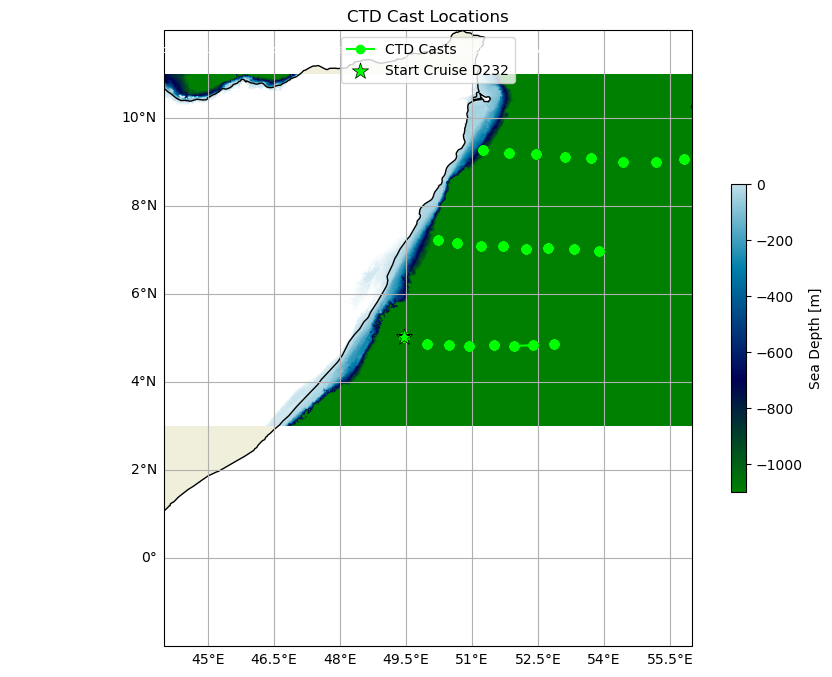

In [31]:
"""
This cell loads the bathymetry data and plots all the different lat/lon points of the CTD casts over the map that is plotted using the 
bathymetry. 
"""
# Load bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot bathymetry
tp = ax.pcolormesh(bathy.lon, bathy.lat, bathy.elevation, cmap='ocean', vmin=-1100, vmax=100, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left', 'bottom'], zorder=0)

# Plot CTD cast locations
if data:
    ax.plot([profile['lon'] for profile in data], [profile['lat'] for profile in data], '-o',
            transform=ccrs.PlateCarree(), c='lime', label='CTD Casts')
    ax.scatter(data[0]['lon'], data[0]['lat'], c='lime', marker='*', s=150, zorder=2,
               transform=ccrs.PlateCarree(), edgecolors='k', linewidths=.5, label='Start Cruise D232')
    ax.legend(loc='upper center')
else:
    print("Warning: No CTD data found. Skipping CTD cast locations.")

# Set title and extent
ax.set_title('CTD Cast Locations')
ax.set_extent([44, 56, -2, 12])  # [min_lon, max_lon, min_lat, max_lat]

# Add colorbar
cb = fig.colorbar(tp, ax=ax, shrink=.5)
cb.ax.set_ylim([-1100, 0])
cb.set_label('Sea Depth [m]')

info_text = bathy.attrs.get('title', 'GEBCO 2024 Grid')  # Use 'title' or another available attribute
_ = ax.text(40.5, 11.5, info_text, c='w', fontsize=8)  # Adjust position as needed

plt.show()

In [32]:
"""
This cell defines constants and a function that calculates the density per profile, meaning per CTD cast, from the salinity and temperature.
For this, the relation that is given in tutorial 3 (I believe) is used. If plot is set to true,
t also poops out a plot of the density as a function of depth for every profile. 
"""
# Constants
alpha_T = 1e-4  # Thermal expansion coefficient
beta_S = 7e-4   # Haline contraction coefficient
dens0 = 1027    # Reference density (kg/m³)
def calc_density(profile, plot=False):
    """
    Calculate density from a profile containing salinity, temperature, and depth.
    
    Parameters:
        profile (dict): A dictionary containing 'salinity', 'temperature', 'z', and 'trajectory'.
    """
    S = profile['salinity']
    T = profile['temperature']
    depth = profile['depth']

    # Reference salinity and temperature (surface value)
    S0 = S[0]
    T0 = T[0]

    # Calculate density
    dens = dens0 * (1 - (alpha_T * (T - T0)) + (beta_S * (S - S0)))

    # Plot
    if plot==True:
        plt.figure(figsize=(8, 6))
        plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")
        plt.xlabel('Density (kg/m³)')
        plt.ylabel('Depth (m)')
        plt.title('Density Profile')
        plt.grid()
        plt.legend()
        plt.show()

    return dens

In [33]:
"""
This cell processes CTD cast data into organized profiles. It:

1. Groups measurements by trajectory (CTD cast).
2. Separates downcast (descending) and upcast (ascending) sections.
3. Filters out invalid measurements (NaNs) and small depth fluctuations.
4. Provides sorting options:
   - "cast": Sorts downcast/upcast sections separately.
   - "depth": Sorts all measurements by depth (mixes casts).
5. Calculates density using either:
   - A simple linear approximation.
   - A more accurate function (e.g., TEOS-10).
6. Preserves metadata (location, time, trajectory, transect ID).

Processing modes:
- "downcast": Only descending measurements.
- "upcast": Only ascending measurements.
- "both": Both casts, with sorting control.

Output: A list of profiles with depth, salinity, temperature, density, and metadata.
"""

from collections import defaultdict
import numpy as np

# Configuration parameters
PROCESSING_MODE = "both"          # Options: "both", "downcast", "upcast"
COMBINED_SORT_MODE = "depth"       # Options: "cast" (preserve sections), "depth" (full sort)
MIN_DEPTH_CHANGE = 0.5            # meters, minimum depth change for cast detection
SORT_TRAJECTORIES = True          # Sort stations along transect
USE_SIMPLE_DENSITY = False        # Use linear density approximation

def detect_cast_sections(depths, min_change=0.5):
    """Identify downcast/upcast sections using depth changes"""
    sections = []
    current_dir = None
    current_start = 0
    
    for i in range(1, len(depths)):
        delta = depths[i] - depths[i-1]
        
        if abs(delta) < min_change:
            continue  # Ignore small fluctuations
            
        new_dir = 'down' if delta > 0 else 'up'
        
        if new_dir != current_dir:
            if current_dir is not None:
                sections.append((current_dir, current_start, i-1))
            current_dir = new_dir
            current_start = i
    
    if current_dir is not None:
        sections.append((current_dir, current_start, len(depths)-1))
    
    return sections

def process_combined_data(valid_obs):
    """Handle combined cast processing with sorting options"""
    if COMBINED_SORT_MODE == "depth":
        # Full depth sorting (original cell behavior)
        sorted_obs = sorted(valid_obs, key=lambda x: x['z'])
        for obs in sorted_obs:
            obs['cast_direction'] = 'combined'
        return sorted_obs
    
    # Cast-based processing (improved cell behavior)
    depths = np.array([obs['z'] for obs in valid_obs])
    sections = detect_cast_sections(depths, MIN_DEPTH_CHANGE)
    
    processed = []
    for dir, start, end in sections:
        section_obs = valid_obs[start:end+1]
        section_depths = [obs['z'] for obs in section_obs]
        
        # Sort section appropriately
        sort_idx = np.argsort(section_depths) if dir == 'down' else np.argsort(-np.array(section_depths))
        
        for i in sort_idx:
            obs = section_obs[i]
            obs['cast_direction'] = dir
            processed.append(obs)
    
    return processed

# Group data by trajectory
grouped_data = defaultdict(list)
for obs in data:
    grouped_data[obs['trajectory']].append(obs)

profiles = []
for trajectory in sorted(grouped_data.keys()) if SORT_TRAJECTORIES else grouped_data.keys():
    observations = grouped_data[trajectory]
    
    # Sort by time and filter NaNs
    time_sorted = sorted(observations, key=lambda x: x['time'])
    valid_obs = [obs for obs in time_sorted if not any(
        np.isnan(obs[k]) for k in ['salinity', 'temperature', 'z'])]
    
    if not valid_obs:
        continue
    
    # Process based on mode
    if PROCESSING_MODE == "both":
        processed_obs = process_combined_data(valid_obs)
    else:
        processed_obs = process_cast(valid_obs, PROCESSING_MODE)
        
    if not processed_obs:
        continue
        
    # Create final arrays
    z = np.array([obs['z'] for obs in processed_obs])
    salinity = np.array([obs['salinity'] for obs in processed_obs])
    temperature = np.array([obs['temperature'] for obs in processed_obs])
    
    # Density calculation
    if USE_SIMPLE_DENSITY:
        dens = 1027 * (1 - 1e-4*(temperature - temperature[0]) + 7e-4*(salinity - salinity[0]))
    else:
        dens = calc_density({
            'salinity': salinity,
            'temperature': temperature,
            'depth': z
        })
    
    profiles.append({
        'trajectory': trajectory,
        'density': dens,
        'salinity': salinity,
        'temperature': temperature,
        'depth': z,
        'lat': processed_obs[0]['lat'],
        'lon': processed_obs[0]['lon'],
        'time': processed_obs[0]['time'],
        'transect_id': 3 if processed_obs[0]['lat'] > 8 else 2 if processed_obs[0]['lat'] > 6 else 1,
        'cast_directions': [obs['cast_direction'] for obs in processed_obs]
    })

# Print verification
if profiles:
    print(f"Processing Mode: {PROCESSING_MODE} ({COMBINED_SORT_MODE} sort)")
    print(f"First profile depth sequence:", profiles[0]['depth'][::len(profiles[0]['depth'])//10])
    print(f"Cast directions:", profiles[0]['cast_directions'][::len(profiles[0]['cast_directions'])//10])

Processing Mode: both (depth sort)
First profile depth sequence: [-2771. -2491. -2221. -1941. -1671. -1391. -1121.  -841.  -571.  -291.
   -21.]
Cast directions: ['combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined']


In [34]:
data

[{'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:00'),
  'temperature': 26.256418228149414,
  'salinity': 34.966346740722656,
  'z': -11.0,
  'trajectory': 38,
  'obs': 0,
  'cast_direction': 'combined'},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:10'),
  'temperature': 26.260557174682617,
  'salinity': 34.970802307128906,
  'z': -21.0,
  'trajectory': 38,
  'obs': 1,
  'cast_direction': 'combined'},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:20'),
  'temperature': 26.26323127746582,
  'salinity': 34.97873306274414,
  'z': -31.0,
  'trajectory': 38,
  'obs': 2,
  'cast_direction': 'combined'},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:30'),
  'temperature': 26.26406478881836,
  'salinity': 34.988609313964844,
  'z': -41.0,
  'trajectory': 38,
  'obs': 3,
  'cast_direction': 'combined'},

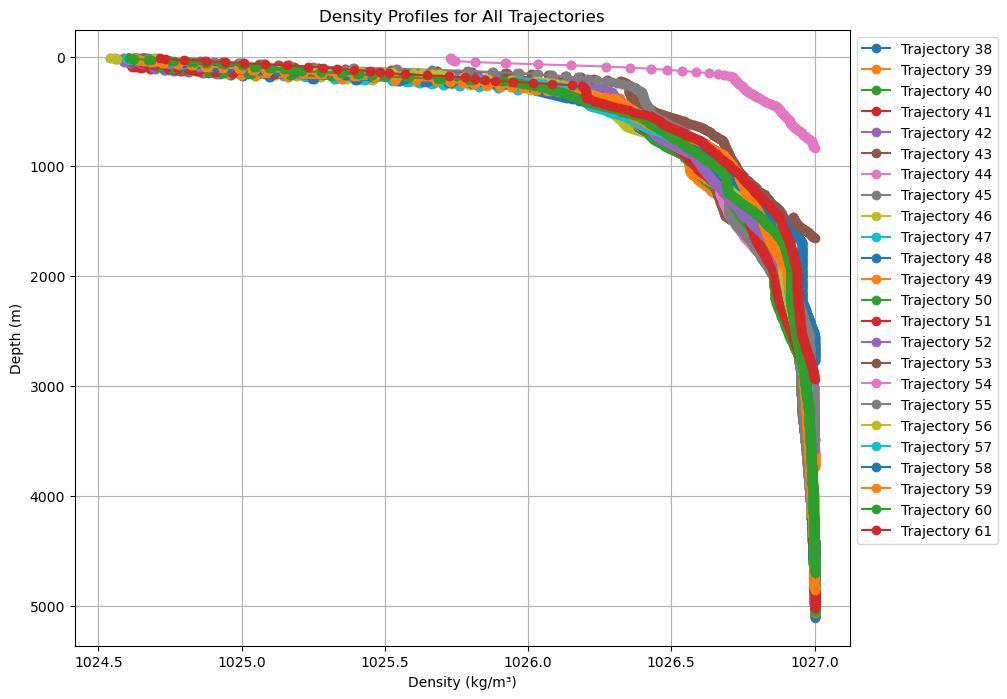

In [35]:
"""
This cell plots the density profiles of all the different CTD casts. It uses the previously defined function to calculate the density and then plots it.
"""
plt.figure(figsize=(10, 8))

for profile in profiles:
    dens = calc_density(profile, plot=False)
    depth = profile['depth']
    plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")

plt.xlabel('Density (kg/m³)')
plt.ylabel('Depth (m)')
plt.title('Density Profiles for All Trajectories')
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.gca().invert_yaxis()

# Save the plot
plt.savefig('density_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# Extract density and depth arrays for all stations
density_profiles = [profile['density'] for profile in profiles]
depth_profiles = [profile['depth'] for profile in profiles]

# Ensure all profiles have the same depth levels (interpolate if necessary)
# Example: Interpolate to a common depth grid (adjust resolution as needed)
common_depth = np.linspace(np.min([np.min(z) for z in depth_profiles]), 
                           np.max([np.max(z) for z in depth_profiles]), 
                           100)
density_interp = []
for dens, z in zip(density_profiles, depth_profiles):
    dens_interp = np.interp(common_depth, z, dens)
    density_interp.append(dens_interp)

density_interp = np.array(density_interp)  # Shape: (n_stations, n_depth_levels)



In [37]:
"""
This cell plots cross-sectional views of CTD data for specified transects. It:

1. Takes profiles and bathymetry data as input.
2. Interpolates CTD measurements (temperature, salinity, or density) onto a regular grid.
3. Masks data below the seafloor using bathymetry.
4. Plots the parameter (temperature, salinity, or density) with:
   - A colormap specific to the parameter (thermal for temperature, haline for salinity, dense for density).
   - Isopycnal lines (constant density contours) for temperature and salinity plots.
   - Seafloor line and CTD measurement locations.
5. Handles transect-specific details:
   - Inverts the x-axis for Transect 2 to match its orientation.
   - Customizes x-axis labels based on transect direction.

Inputs:
- profiles: List of CTD profiles with depth, parameter values, and metadata.
- transect_ids: List of transect IDs to plot.
- bathy: Bathymetry data for masking.
- parameter: Parameter to plot ('temperature', 'salinity', or 'density').
- n_interp: Number of interpolation points for the grid.

Output:
- Cross-section plots for each transect, showing the parameter distribution with isopycnals (if applicable) and seafloor.
"""

import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.interpolate import griddata
import cmocean  # Import cmocean for colormaps

def plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='temperature', n_interp=100):
    """
    Plot cross-sections for specified transects with bathymetry masking.
    Uses custom colormaps for temperature, salinity, and density.
    Adds isopycnal lines for temperature and salinity plots only.
    """
    # Define colormaps for each parameter
    colormaps = {
        'temperature': cmocean.cm.thermal,  # Thermal colormap for temperature
        'salinity': cmocean.cm.haline,      # Haline colormap for salinity
        'density': cmocean.cm.dense          # Dense colormap for density
    }

    for transect_id in transect_ids:
        transect_profiles = [p for p in profiles if p['transect_id'] == transect_id]
        if not transect_profiles:
            print(f"No profiles found for transect {transect_id}. Skipping.")
            continue

        # Get station coordinates and ensure CTD depths are positive
        lons = [p['lon'] for p in transect_profiles]
        lats = [p['lat'] for p in transect_profiles]
        ctd_depths = [np.abs(p['depth']) for p in transect_profiles]

        # Extract and convert bathymetry (elevation to depth)
        bathymetry = []
        for lon, lat in zip(lons, lats):
            elev = bathy.elevation.sel(lon=lon, lat=lat, method="nearest").values
            bathymetry.append(-elev if elev < 0 else elev)
        bathymetry = np.array(bathymetry)

        # Calculate distances between stations
        distances = [0]
        for i in range(1, len(transect_profiles)):
            prev = (transect_profiles[i-1]['lat'], transect_profiles[i-1]['lon'])
            curr = (transect_profiles[i]['lat'], transect_profiles[i]['lon'])
            distances.append(distances[-1] + geodesic(prev, curr).meters)

        # Define depth grid from surface (0) to max basin depth (using bathymetry)
        max_depth = np.nanmax(bathymetry)
        common_z = np.linspace(0, max_depth, 100)

        # Create interpolation grid (x: distance, z: depth)
        xi = np.linspace(0, distances[-1], n_interp)
        zi = common_z
        xi_grid, zi_grid = np.meshgrid(xi, zi)

        # Interpolate bathymetry to grid (seafloor line)
        bathymetry_interp = np.interp(xi, distances, bathymetry)

        # Interpolate parameter data to common grid
        values = []
        for p in transect_profiles:
            depths = np.abs(p['depth'])
            order = np.argsort(depths)
            depths_sorted = np.array(depths)[order]
            param_sorted = np.array(p[parameter])[order]
            interp_vals = np.interp(common_z, depths_sorted, param_sorted, left=np.nan, right=np.nan)
            values.append(interp_vals)
        values = np.array(values)

        # Create scattered grid points from the original profiles
        x_points = np.repeat(distances, len(common_z))
        z_points = np.tile(common_z, len(transect_profiles))
        values_flat = values.flatten()

        # Regrid the scattered data to a regular grid for plotting
        grid = griddata((x_points, z_points), values_flat, (xi_grid, zi_grid), method='linear')

        # Mask data below the seafloor
        grid_masked = np.where(zi_grid > bathymetry_interp, np.nan, grid)

        # --- Add isopycnal lines (constant density contours) ---
        # Only add isopycnals for temperature and salinity plots
        if parameter in ['temperature', 'salinity']:
            # Interpolate density profiles onto the common depth grid
            density_interp = []
            for p in transect_profiles:
                depths = np.abs(p['depth'])
                order = np.argsort(depths)
                depths_sorted = np.array(depths)[order]
                dens_sorted = np.array(p['density'])[order]
                dens_interp = np.interp(common_z, depths_sorted, dens_sorted, left=np.nan, right=np.nan)
                density_interp.append(dens_interp)
            density_interp = np.array(density_interp)

            # Create scattered grid points for density
            density_flat = density_interp.flatten()

            # Regrid the density data to a regular grid for plotting
            density_grid = griddata((x_points, z_points), density_flat, (xi_grid, zi_grid), method='linear')

            # Mask density data below the seafloor
            density_grid_masked = np.where(zi_grid > bathymetry_interp, np.nan, density_grid)

            # Define isopycnal levels (reduce clutter)
            min_density = np.nanmin(density_grid_masked)
            max_density = np.nanmax(density_grid_masked)
            levels = np.linspace(min_density + 0.1, max_density - 0.1, 7)  # Fewer levels, avoid surface and bottom
            levels = levels[::2]  # Further reduce the number of levels

        # Plot
        plt.figure(figsize=(12, 6))
        
        # Use the appropriate colormap for the parameter
        cmap = colormaps.get(parameter, 'viridis')  # Default to 'viridis' if parameter not found
        pcm = plt.pcolormesh(xi_grid, zi_grid, grid_masked, shading='auto', cmap=cmap)
        plt.colorbar(pcm, label=parameter)

        # Overlay isopycnal lines (only for temperature and salinity)
        if parameter in ['temperature', 'salinity']:
            cs = plt.contour(xi_grid, zi_grid, density_grid_masked, levels=levels, colors='k', linewidths=0.5)
            plt.clabel(cs, inline=True, fontsize=8, fmt='%.2f')  # Label contours

        # Plot seafloor line
        plt.plot(xi, bathymetry_interp, 'k-', linewidth=1.5, label='Seafloor')

        # Plot CTD measurements (ensure depths are positive)
        plt.scatter(
            np.repeat(distances, [len(d) for d in ctd_depths]),
            np.concatenate(ctd_depths),
            c='k', s=10, alpha=0.01, label='CTD Measurements'
        )

        # Customize x-axis label for Transect 2
        if transect_id == 2:
            plt.gca().invert_xaxis()
            xlabel = 'Distance from eastmost point of transect (m)'
        else:
            xlabel = 'Distance from westmost point of transect (m)'

        plt.gca().invert_yaxis()  # Invert so surface is at the top
        plt.title(f'Transect {transect_id} - {parameter.capitalize()}')
        plt.xlabel(xlabel)  # Use custom x-axis label
        plt.ylabel('Depth (m)')
        plt.legend()
        plt.show()

In [38]:
from geopy.distance import geodesic
import numpy as np

def calculate_zonal_velocity(profiles, common_depth, reference_depth=2000):
    """
    Calculates east-west velocity using three parallel transects with stations
    at similar longitudes. Assumes:
    - Transects are numbered 1-3 and parallel (e.g., all north-south)
    - At least one station per transect exists at common longitudes
    
    Parameters:
    - profiles: List of processed profiles (with depth, density, lat, lon)
    - common_depth: Common depth grid (same as used in previous processing)
    - reference_depth: Depth of no motion (default: 2000m)
    
    Returns:
    - Dictionary of velocity profiles keyed by longitude
    """
    # Constants
    g = 9.81  # m/s²
    rho0 = 1027  # kg/m³
    #f = 1e-4  # Coriolis parameter (adjust for your latitude)
    omega = 7.2921e-5  # Earth's angular velocity [rad/s]
    # Group profiles by longitude (rounded to 0.01° precision)
    lon_groups = {}
    for p in profiles:
        lon_key = round(p['lon'], 2)
        if lon_key not in lon_groups:
            lon_groups[lon_key] = {1: [], 2: [], 3: []}
        lon_groups[lon_key][p['transect_id']].append(p)

    velocity_profiles = {}

    # Process each longitude group with data from all 3 transects
    for lon, transect_dict in lon_groups.items():
        # Check we have at least one station per transect
        if not all(len(v) > 0 for v in transect_dict.values()):
            continue

        # Select stations closest to this longitude
        stations = []
        for tid in [1, 2, 3]:
            # Find station in this transect with longitude closest to group key
            closest = min(transect_dict[tid], key=lambda x: abs(x['lon'] - lon))
            stations.append(closest)

        # Sort stations by latitude (north to south)
        stations.sort(key=lambda x: x['lat'], reverse=True)

        # Extract and interpolate densities
        densities = []
        lats = []
        for station in stations:
            # Interpolate to common depth grid
            dens_interp = np.interp(common_depth, station['depth'], station['density'])
            densities.append(dens_interp)
            lats.append(station['lat'])
        densities = np.array(densities)
        transect_lats = [p['lat'] for p in transect_profiles]
        mean_lat = np.mean(transect_lats)
        f = 2 * omega * np.sin(np.deg2rad(mean_lat))
        # Calculate meridional distances between stations (north-south)
        dy = []
        for i in range(1, len(stations)):
            dy.append(geodesic((lats[i-1], lon), (lats[i], lon)).meters)
        total_dy = sum(dy)
        
        # Compute density gradient (∂ρ/∂y) using central differences
        drho_dy = np.gradient(densities, lats, axis=0)

        # Thermal wind equation for east-west velocity shear: ∂u/∂z = (g/(ρ0f))(-∂ρ/∂y)
        du_dz = (g / (rho0 * f)) * (-drho_dy)

        # Integrate vertically to get velocity
        dz = np.gradient(common_depth)
        u = np.cumsum(du_dz * dz, axis=1)

        # Apply reference velocity at specified depth
        ref_idx = np.argmin(np.abs(common_depth - reference_depth))
        u -= u[:, ref_idx][:, np.newaxis]  # Subtract reference velocity

        # Store results
        velocity_profiles[lon] = {
            'longitude': lon,
            'latitudes': lats,
            'depth': common_depth,
            'velocity': u,
            'stations': [s['trajectory'] for s in stations]
        }

    return velocity_profiles

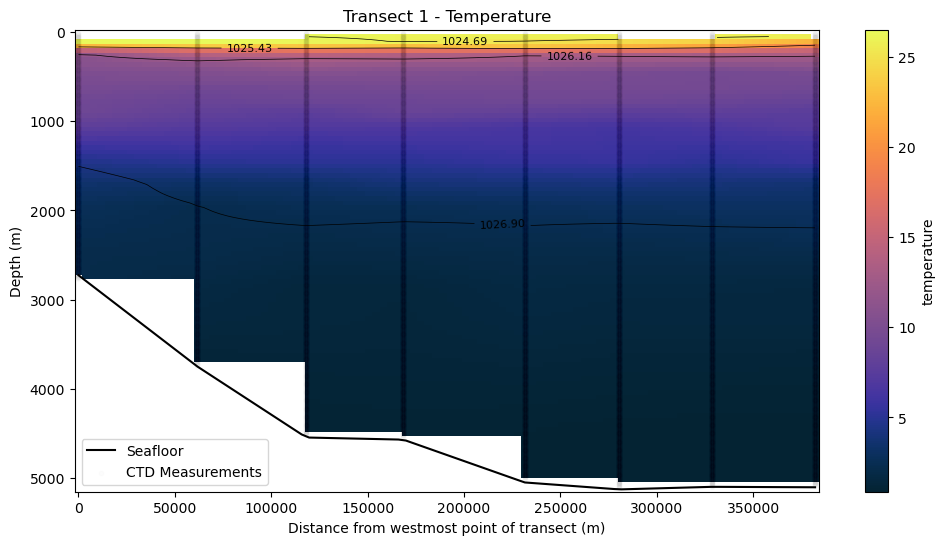

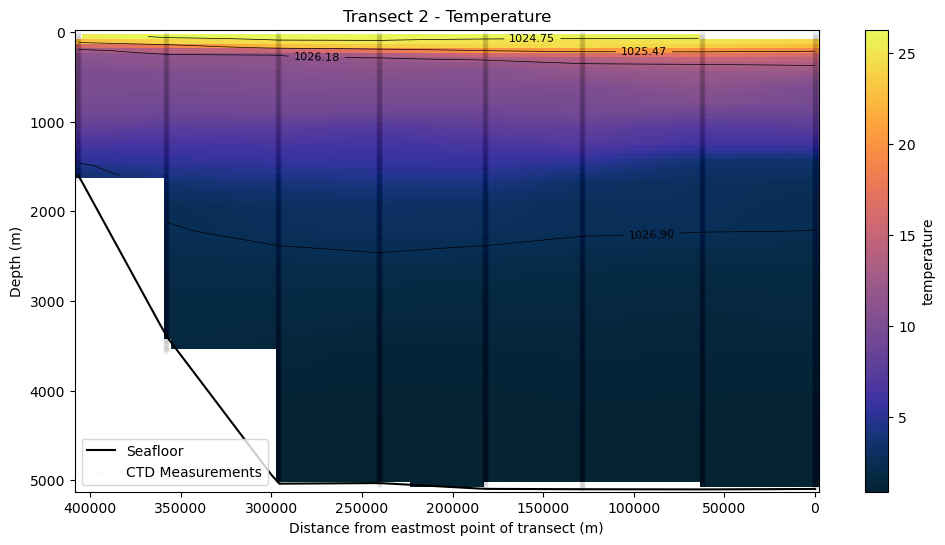

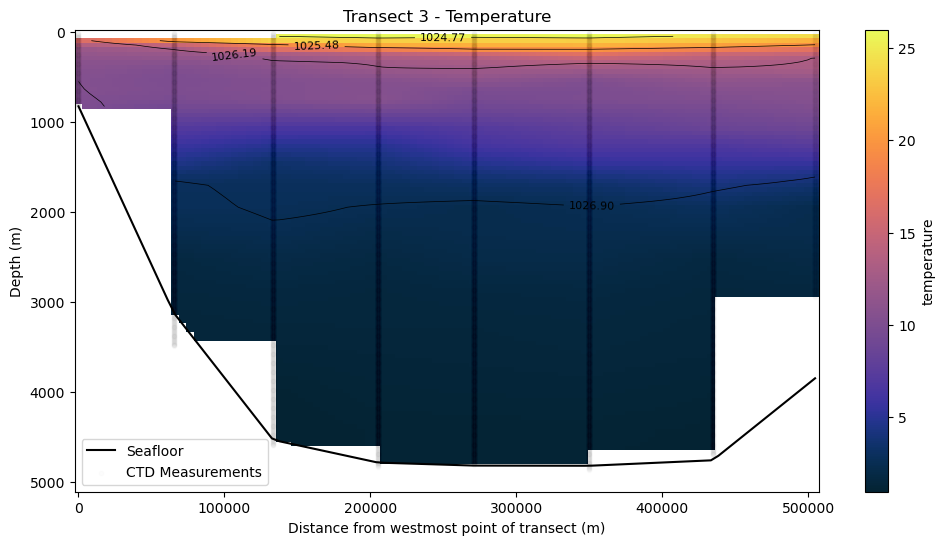

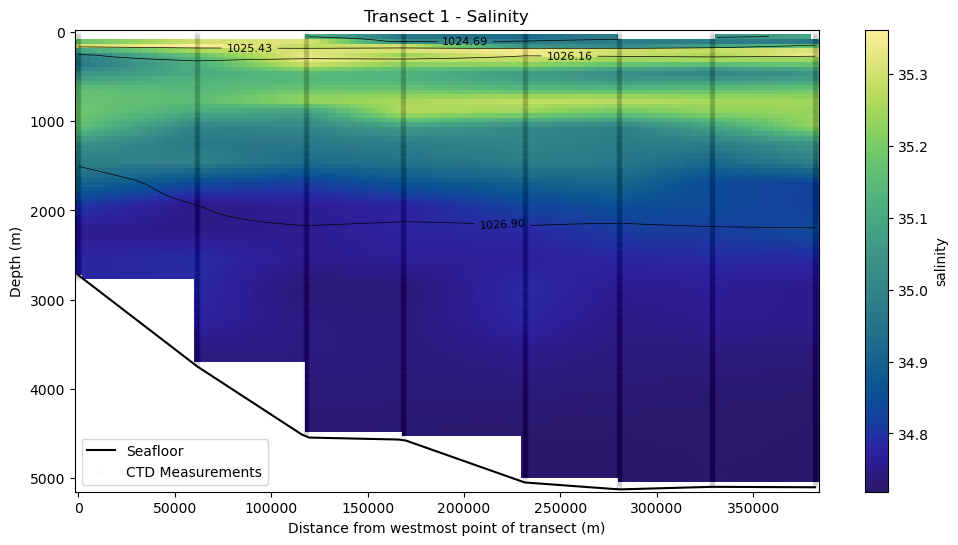

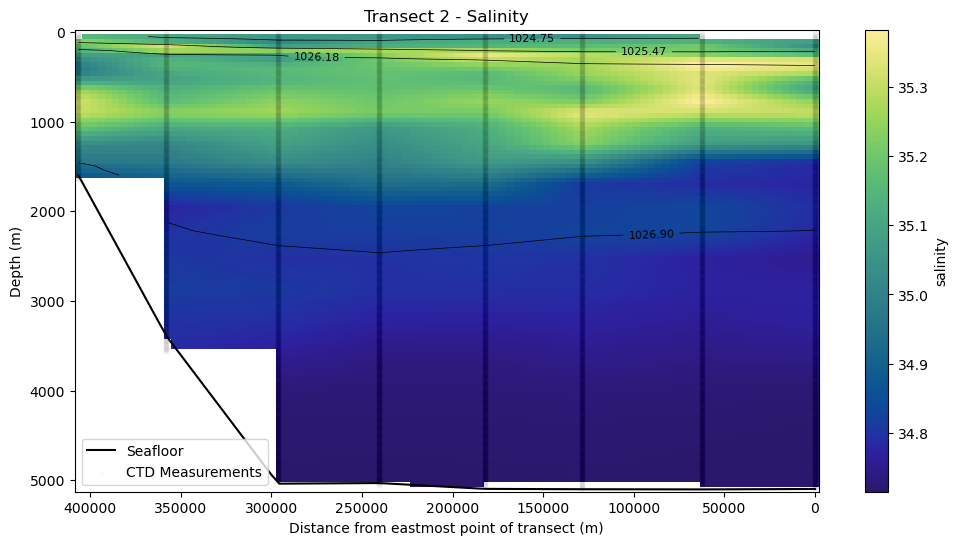

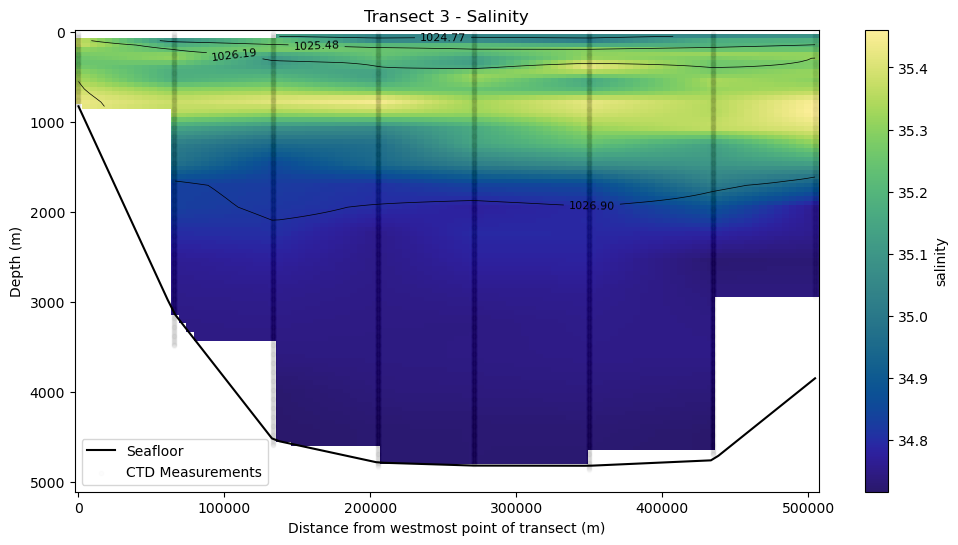

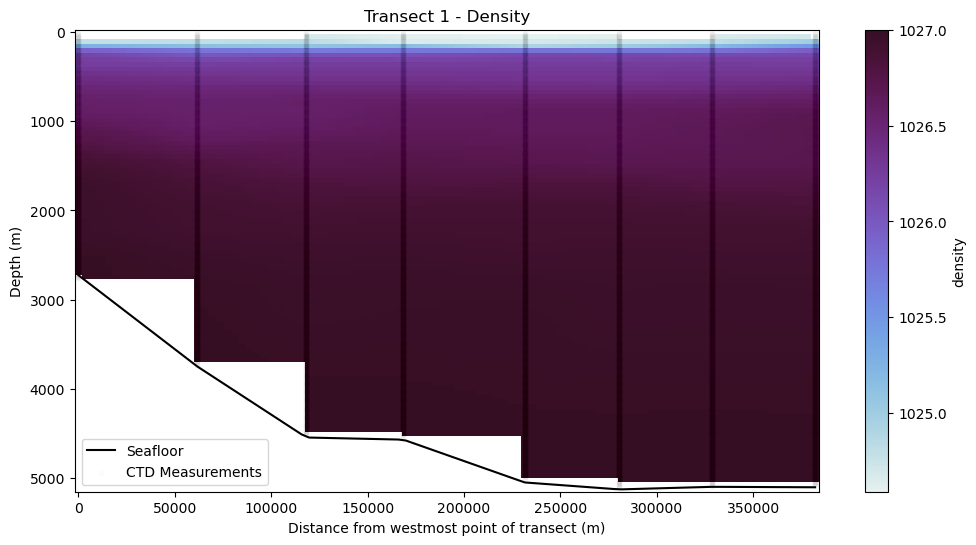

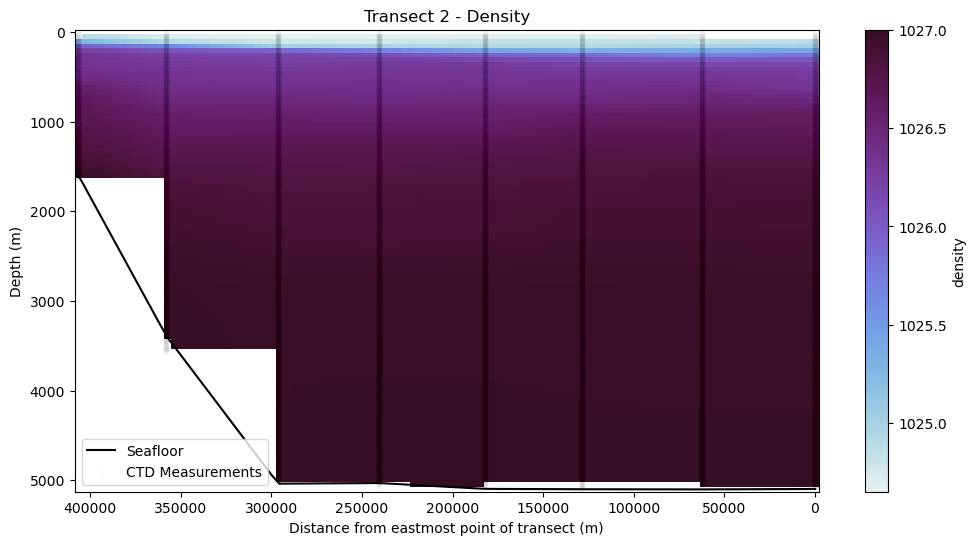

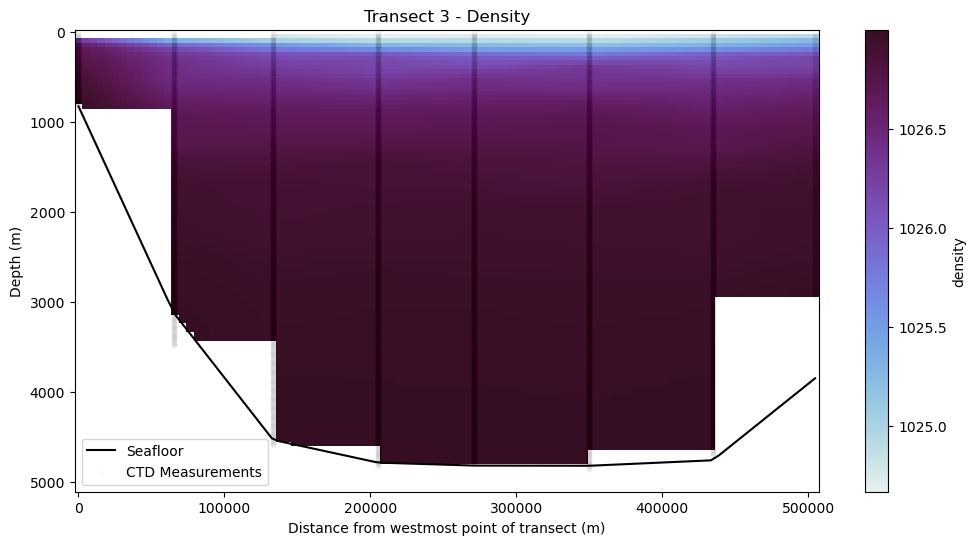

In [39]:
# First load your bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Then plot cross-sections
transect_ids = [1, 2, 3]  # Your actual transect IDs
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='temperature')
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='salinity')
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='density')

In [40]:
from geopy.distance import geodesic
import numpy as np

def calculate_transport(profiles, common_depth, reference_depth=2000):
    """
    Calculates geostrophic velocity and transport for each transect using thermal wind relationship.
    Now includes proper latitude-dependent Coriolis parameter calculation.
    """
    # Constants
    g = 9.81  # m/s²
    rho0 = 1027  # Reference density (kg/m³)
    omega = 7.2921e-5  # Earth's angular velocity [rad/s]

    # Group profiles by transect
    transects = {}
    for profile in profiles:
        transect_id = profile['transect_id']
        if transect_id not in transects:
            transects[transect_id] = []
        transects[transect_id].append(profile)

    # Process each transect separately
    for transect_id, transect_profiles in transects.items():
        print(f"\nProcessing Transect {transect_id}")

        # -------------------------------------------------------------
        # 1. Calculate Coriolis parameter for this transect
        # -------------------------------------------------------------
        transect_lats = [p['lat'] for p in transect_profiles]
        mean_lat = np.mean(transect_lats)
        f = 2 * omega * np.sin(np.deg2rad(mean_lat))
        print(f"Mean latitude: {mean_lat:.4f}°, Coriolis: {f:.3e} s⁻¹")

        # -------------------------------------------------------------
        # 2. Compute distances between stations
        # -------------------------------------------------------------
        dx_list = []
        for i in range(1, len(transect_profiles)):
            prev = transect_profiles[i-1]
            curr = transect_profiles[i]
            dx = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).meters
            dx_list.append(dx)

        x_transect = np.insert(np.cumsum(dx_list), 0, 0)

        # -------------------------------------------------------------
        # 3. Interpolate density to common depth grid
        # -------------------------------------------------------------
        density_interp = np.array([
            np.interp(common_depth, p['depth'], p['density'])
            for p in transect_profiles
        ])

        # -------------------------------------------------------------
        # 4. Thermal wind calculations
        # -------------------------------------------------------------
        drho_dx = np.gradient(density_interp, x_transect, axis=0)
        du_dz = (g / (rho0 * f)) * drho_dx  # Sign convention matches depth-positive-down

        # -------------------------------------------------------------
        # 5. Integrate velocity and apply reference
        # -------------------------------------------------------------
        dz = np.gradient(common_depth)
        u = np.cumsum(du_dz * dz, axis=1)
        
        # Apply reference velocity
        ref_idx = np.argmin(np.abs(common_depth - reference_depth))
        u -= u[:, ref_idx][:, np.newaxis]

        # -------------------------------------------------------------
        # 6. Calculate transport
        # -------------------------------------------------------------
        transport_per_station = np.trapz(u, x=common_depth, axis=1)
        total_transport = np.trapz(transport_per_station, x=x_transect)

        print(f"Transect {transect_id} transport: {total_transport:.2f} m³/s")

    return transects

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.interpolate import griddata
import cmocean  # Import cmocean for colormaps
import matplotlib.colors as mcolors  # Import mcolors for norm

def plot_transect_velocity_and_transport(profiles, transect_ids, bathy, n_interp=100):
    """
    Plot geostrophic velocity and transport for specified transects computed 
    from density profiles using the thermal wind balance, with bathymetry masking 
    and CTD measurement sites included.
    
    Parameters:
        profiles (list): List of profile dictionaries. Each must contain 
            'transect_id', 'lat', 'lon', 'depth', and 'density'.
        transect_ids (list): List of transect IDs to plot.
        bathy: Bathymetry dataset with an 'elevation' variable.
        n_interp (int): Number of interpolation points along the transect.
    """
    # --- Constants for thermal wind calculation ---
    g = 9.81         # gravitational acceleration (m/s²)
    rho0 = 1027      # reference density (kg/m³)
    #f = 1e-4         # Coriolis parameter (s⁻¹)
    reference_depth = 2000  # reference depth (m) for zero velocity
    norm = mcolors.CenteredNorm(vcenter=0, halfrange=0.8)  # halfrange=1 makes range [-1, 1]
    cmap = cmocean.cm.balance
    omega = 7.2921e-5  # Earth's angular velocity [rad/s]

    # --- Determine a common depth grid spanning from the surface to maximum measured depth ---
    valid_profiles = [p for p in profiles if len(p['depth']) > 0]
    if not valid_profiles:
        print("No valid profiles with non-empty depth arrays.")
        return
    
    # Use full depth range from the surface (0 m) to the maximum measured depth across profiles
    max_depth = max([np.max(np.abs(p['depth'])) for p in valid_profiles])
    common_z = np.linspace(0, max_depth, 100)
    
    for transect_id in transect_ids:
        transect_profiles = [p for p in profiles if p['transect_id'] == transect_id]
        
        # Reverse station order for east-west transects (e.g., Transect 2)
        if transect_id == 2:
            transect_profiles = transect_profiles[::-1]  # Reverse the list

        # Recompute distances after reversing
        distances = [0]
        for i in range(1, len(transect_profiles)):
            prev = (transect_profiles[i-1]['lat'], transect_profiles[i-1]['lon'])
            curr = (transect_profiles[i]['lat'], transect_profiles[i]['lon'])
            distances.append(distances[-1] + geodesic(prev, curr).meters)

        # Filter profiles for the current transect
        if not transect_profiles:
            print(f"No profiles found for transect {transect_id}. Skipping.")
            continue
        
        # --- Compute cumulative distances along the transect ---
        distances = [0]
        for i in range(1, len(transect_profiles)):
            prev = (transect_profiles[i-1]['lat'], transect_profiles[i-1]['lon'])
            curr = (transect_profiles[i]['lat'], transect_profiles[i]['lon'])
            distances.append(distances[-1] + geodesic(prev, curr).meters)
        x_transect = np.array(distances)
        
        # --- Compute bathymetry (seafloor depth) at each station ---
        station_bathy = []
        for p in transect_profiles:
            lon = p['lon']
            lat = p['lat']
            elev = bathy.elevation.sel(lon=lon, lat=lat, method="nearest").values
            # Convert elevation to positive depth (if elevation is negative, that means depth)
            station_bathy.append(-elev if elev < 0 else elev)
        station_bathy = np.array(station_bathy)
        
        # Interpolate the station bathymetry onto a uniform horizontal grid
        xi = np.linspace(0, distances[-1], n_interp)
        bathy_interp = np.interp(xi, x_transect, station_bathy)
        
        # --- Interpolate density profiles onto the common depth grid ---
        density_interp = []
        for p in transect_profiles:
            if len(p['depth']) == 0:
                print(f"Skipping station in transect {transect_id} due to empty depth array.")
                continue
            # Ensure depths are positive and sort the arrays
            depths = np.abs(p['depth'])
            order = np.argsort(depths)
            depths_sorted = np.array(depths)[order]
            dens_sorted = np.array(p['density'])[order]
            # Extrapolate by extending the boundary values so the entire grid gets filled
            dens_interp = np.interp(common_z, depths_sorted, dens_sorted,
                                    left=dens_sorted[0], right=dens_sorted[-1])
            density_interp.append(dens_interp)
        if len(density_interp) == 0:
            print(f"No valid density data for transect {transect_id}. Skipping.")
            continue
        density_interp = np.array(density_interp)
        
        if len(x_transect) != density_interp.shape[0]:
            print(f"Mismatch in profiles and distances for transect {transect_id}. Skipping.")
            continue
        transect_lats = [p['lat'] for p in transect_profiles]
        mean_lat = np.mean(transect_lats)
        print(mean_lat)
        f = 2 * omega * np.sin(np.deg2rad(mean_lat))
        # --- Compute horizontal density gradient along the transect ---
        drho_dx = np.gradient(density_interp, x_transect, axis=0)
        
        # --- Compute vertical gradient in depth ---
        dz = np.gradient(common_z)
        
        # --- Thermal wind: compute vertical shear and integrate in depth ---
        du_dz = (g / (rho0 * f)) * drho_dx
        u = np.cumsum(du_dz * dz, axis=1)
        # Adjust velocity so that it is zero at the reference depth
        ref_idx = np.argmin(np.abs(common_z - reference_depth))
        u = u - u[:, ref_idx:ref_idx+1]
        
        # --- Prepare a uniform grid for plotting the velocity section ---
        xi_grid, zi_grid = np.meshgrid(xi, common_z)
        
        # Create arrays of original data points (each station's x repeated for every depth)
        x_points = np.repeat(x_transect, len(common_z))
        z_points = np.tile(common_z, len(transect_profiles))
        velocities_flat = u.flatten()
        
        # Grid the computed velocities onto the uniform grid
        velocity_grid = griddata((x_points, z_points), velocities_flat,
                                 (xi_grid, zi_grid), method='linear')
        
        # --- Mask grid cells below the seafloor ---
        velocity_grid_masked = np.where(zi_grid > bathy_interp, np.nan, velocity_grid)
        
        # --- Plot the geostrophic velocity section ---
        plt.figure(figsize=(10, 6))
        pcm = plt.pcolormesh(xi_grid, common_z, velocity_grid_masked,
                             cmap=cmap, norm=norm, shading='auto')
        plt.colorbar(pcm, label='Geostrophic Velocity (m/s)')
        
        # Customize x-axis label for Transect 2
        if transect_id == 2:
            xlabel = 'Distance from eastmost point of transect (m)'
        else:
            xlabel = 'Distance from westmost point of transect (m)'
        plt.xlabel(xlabel)
        
        plt.ylabel('Depth (m)')
        plt.title(f'Transect {transect_id} - Geostrophic Velocity Section')
        
        # Plot the seafloor line using the uniform grid
        plt.plot(xi, bathy_interp, 'k-', linewidth=1.5, label='Seafloor')
        
        # --- Plot CTD measurement sites ---
        meas_x = []
        meas_y = []
        for distance, p, station_depth in zip(x_transect, transect_profiles, station_bathy):
            depths = np.abs(p['depth'])
            # Include only measurements above the seafloor at that station
            valid = depths <= station_depth
            if np.any(valid):
                meas_x.extend(np.repeat(distance, np.sum(valid)))
                meas_y.extend(depths[valid])
        plt.scatter(meas_x, meas_y, c='k', alpha=0.01, s=10, label='CTD Measurements')
        
        # Invert y-axis so that shallow depths appear at the top
        #if transect_id == 2:
            #plt.gca().invert_xaxis()  # Invert x-axis for Transect 2
        plt.gca().invert_yaxis()
        plt.legend()
        plt.show()
        
        # --- Calculate transport ---
        transport_per_station = np.trapz(u, x=common_z, axis=1)
        total_transport = np.trapz(transport_per_station, x=x_transect)
        
        # --- Plot transport per station along the transect ---
        plt.figure(figsize=(8, 5))
        plt.plot(x_transect, transport_per_station, 'o-', label='Transport per Station')
        
        # Customize x-axis label for Transect 2
        if transect_id == 2:
            nothing = 0
            #xlabel = 'Distance from eastmost point of transect (m)'
            #plt.gca().invert_xaxis()
        else:
            xlabel = 'Distance from westmost point of transect (m)'
        plt.xlabel(xlabel)
        
        plt.ylabel('Transport per Station (m³/s)')
        plt.title(f'Transect {transect_id}\nTotal Transport = {total_transport:.2f} m³/s')
        plt.grid(True)
        plt.legend()
        plt.show()

4.862532734870911


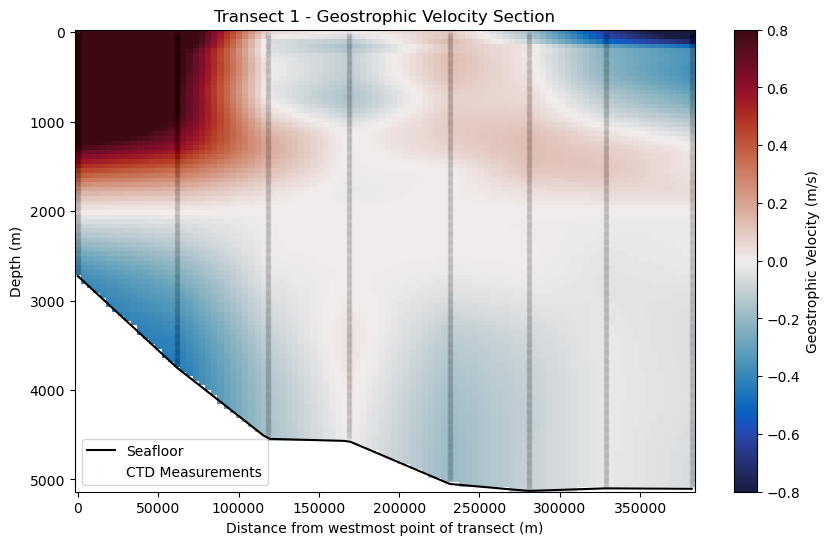

C:\Users\gvp63\AppData\Local\Temp\ipykernel_2508\1121680434.py:175: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_z, axis=1)
C:\Users\gvp63\AppData\Local\Temp\ipykernel_2508\1121680434.py:176: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport = np.trapz(transport_per_station, x=x_transect)


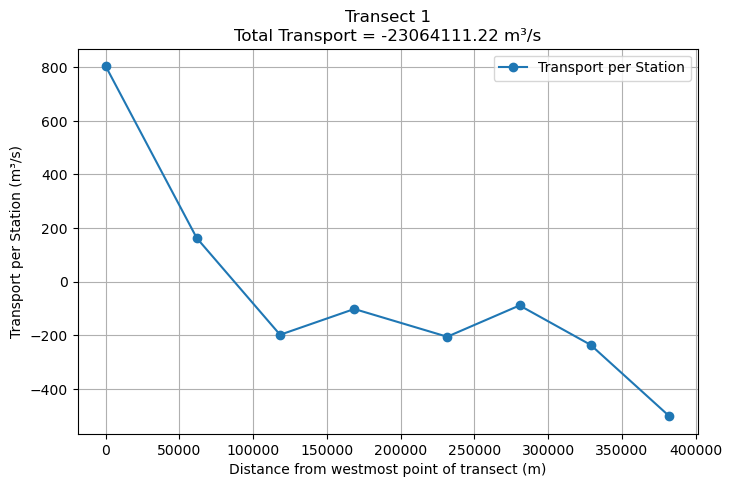

7.080134689807892


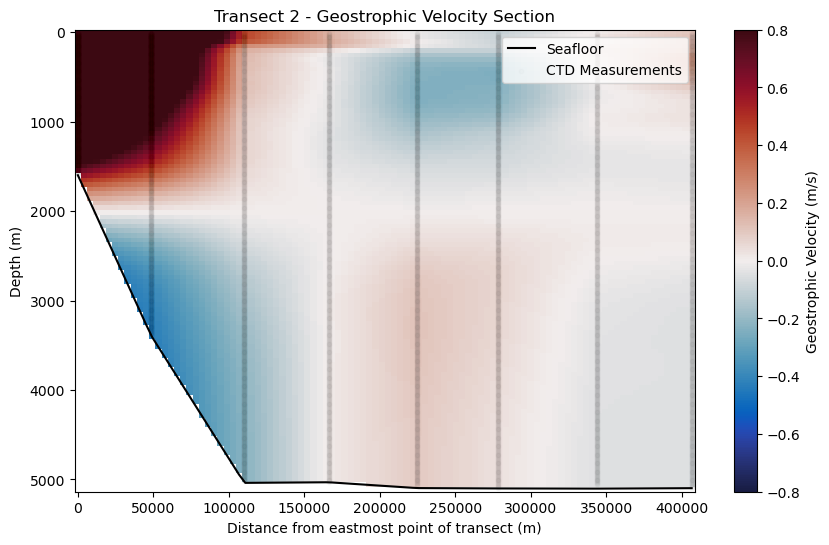

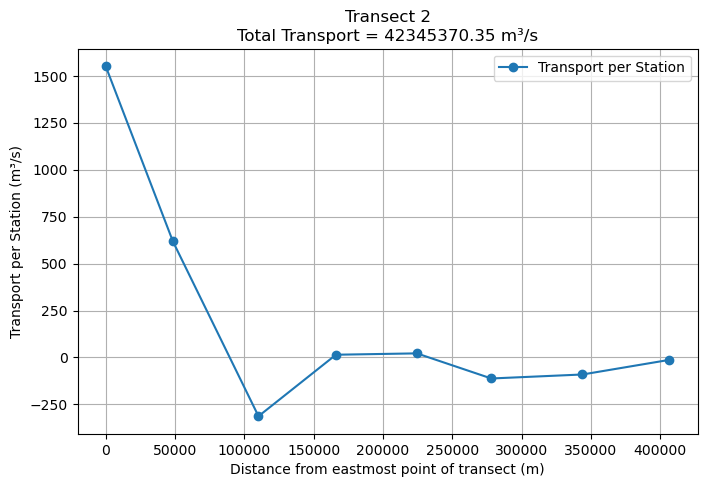

9.115001797676086


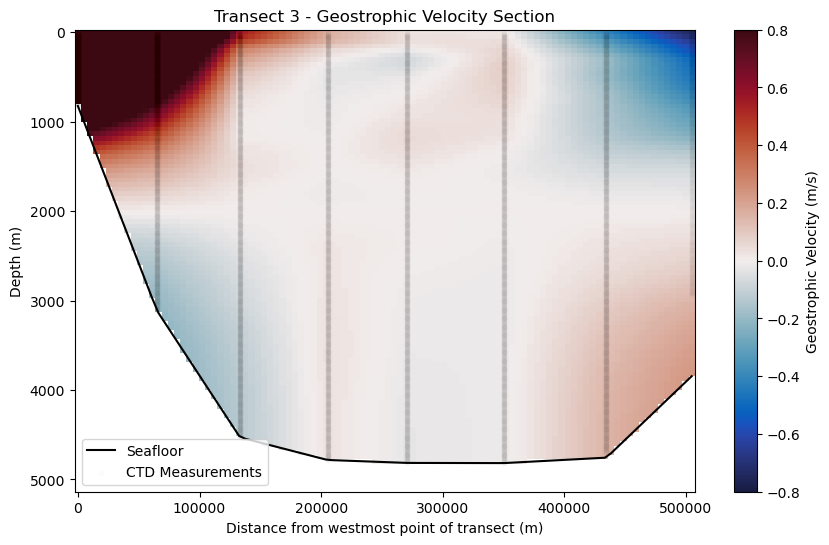

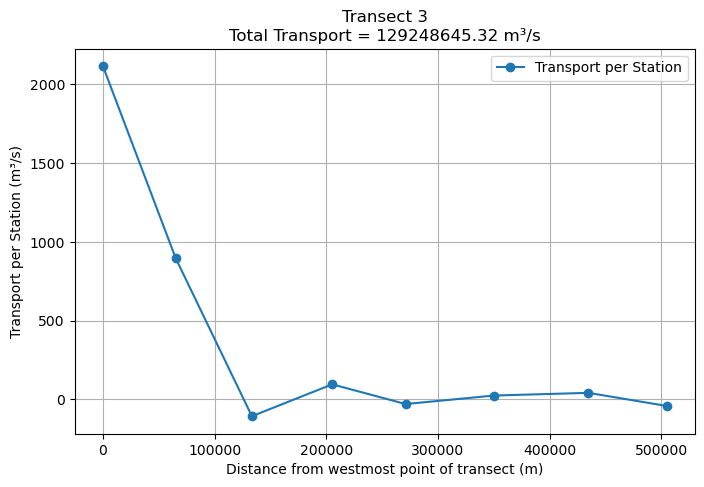

In [42]:
# Example usage:
# Your profiles should include the keys: 'transect_id', 'lat', 'lon', 'depth', 'density'
transect_ids = [1, 2, 3]  # Replace with your actual transect IDs
plot_transect_velocity_and_transport(profiles, transect_ids, bathy)
